In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import datasets
import lightning.pytorch as pl
import torch
import itertools
import timeit
import time
import onnx
import onnxruntime
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

import my_utils
import my_training
import my_datasets

/home/pk/miniconda3/envs/dp-dm-conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Predict on test dataset

In [2]:
def prepare_test_dataset(example: dict, random_generator:random.Random) -> dict:
    image: Image.Image = example["image"]
    image = image.resize((128, 128), resample=Image.Resampling.NEAREST)
    angle = random_generator.randint(0, 3) * 90
    image = image.rotate(angle)
    return {"image": image}

In [3]:
# load dataset from hugging face
hf_test_dataset = datasets.load_dataset("shortery/dm-codes")["test"]

In [4]:
random_generator = random.Random(0)

In [5]:
hf_dataset = hf_test_dataset.map(my_datasets.crop_dm_code)
hf_dataset = hf_dataset.map(lambda x: prepare_test_dataset(x, random_generator))

Map: 100%|██████████| 199/199 [00:01<00:00, 123.30 examples/s]


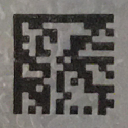

In [8]:
hf_dataset["image"][0]

In [10]:
pd_dataset = pd.DataFrame(hf_dataset)
pd_dataset.head()

,image,tl,tr,br,bl,is_clean,split,text,image_name
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[1680, 1920]","[1656, 1026]","[2547, 1011]","[2571, 1929]",True,test,E51085011W,005.jpg
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2382, 1983]","[1809, 1938]","[1818, 1311]","[2394, 1338]",False,test,E51085011W,006.jpg
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2676, 1407]","[2295, 1935]","[1731, 1437]","[2076, 843]",False,test,E51085011W,007.jpg
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2370, 1719]","[2385, 960]","[3156, 981]","[3159, 1731]",False,test,E51085011W,008.jpg
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2847, 1713]","[2133, 1923]","[1938, 1086]","[2655, 888]",False,test,E51085011W,009.jpg


In [12]:
# add new collumn decoded_text
np_grayscale_images = pd_dataset["image"].map(lambda x: np.asarray(x.convert("L")))
pd_dataset["decoded_text_before_nn"] = np_grayscale_images.map(lambda x: my_utils.decode_dm_code(x))
pd_dataset

,image,tl,tr,br,bl,is_clean,split,text,image_name,decoded_text_before_nn
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[1680, 1920]","[1656, 1026]","[2547, 1011]","[2571, 1929]",True,test,E51085011W,005.jpg,E51085011W
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2382, 1983]","[1809, 1938]","[1818, 1311]","[2394, 1338]",False,test,E51085011W,006.jpg,None
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2676, 1407]","[2295, 1935]","[1731, 1437]","[2076, 843]",False,test,E51085011W,007.jpg,None
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2370, 1719]","[2385, 960]","[3156, 981]","[3159, 1731]",False,test,E51085011W,008.jpg,None
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2847, 1713]","[2133, 1923]","[1938, 1086]","[2655, 888]",False,test,E51085011W,009.jpg,None
...,...,...,...,...,...,...,...,...,...,...
194,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[606, 2202]","[1164, 1845]","[1896, 2499]","[1224, 3093]",False,test,92123605213202401080000053846434,295.jpg,None
195,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[1824, 2790]","[1731, 2136]","[2379, 1923]","[2328, 2418]",False,test,92123605213202401080000053846434,296.jpg,None
196,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[441, 2571]","[1593, 2376]","[1707, 3144]","[444, 3225]",False,test,92123605213202401080000053846434,297.jpg,None
197,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[1344, 2280]","[2235, 1995]","[2646, 2685]","[1710, 3000]",False,test,92123605213202401080000053846434,298.jpg,None


In [41]:
def print_decoding_results(pd_dataset: pd.DataFrame, decoded_text_column: str):
    print("Number of correctly decoded clean codes:", end=" ")
    print(len(pd_dataset[(pd_dataset["is_clean"]) & (pd_dataset[decoded_text_column] == pd_dataset["text"])]), end=" ")
    print("out of", pd_dataset["is_clean"].sum())

    print("Number of undecodable clean codes:", end=" ")
    print(len(pd_dataset[(pd_dataset["is_clean"]) & pd_dataset[decoded_text_column].isna()]), end=" ")
    print("out of", pd_dataset["is_clean"].sum())

    print()

    print("Number of correctly decoded damaged codes:", end=" ")
    print(len(pd_dataset[~(pd_dataset["is_clean"]) & (pd_dataset[decoded_text_column] == pd_dataset["text"])]), end=" ")
    print("out of", (~pd_dataset["is_clean"]).sum())

    print("Number of undecodable damaged codes:", end=" ")
    print(len(pd_dataset[~(pd_dataset["is_clean"]) & pd_dataset[decoded_text_column].isna()]), end=" ")
    print("out of", (~pd_dataset["is_clean"]).sum())


    print("Number of decoded, but not correctly decoded damaged codes:", end=" ")
    print(len(pd_dataset[~(pd_dataset["is_clean"]) & (~pd_dataset[decoded_text_column].isna()) &
                        (pd_dataset[decoded_text_column] != pd_dataset["text"])]), end=" ")
    print("out of", (~pd_dataset["is_clean"]).sum())

    print()
    print("Overall accuracy:")
    num_all = len(pd_dataset)
    num_correctly_decoded = len(pd_dataset[(pd_dataset[decoded_text_column] == pd_dataset["text"])])
    num_decoded = len(pd_dataset[(~pd_dataset[decoded_text_column].isna())])
    print("Decode rate (= correctly_decoded) =", end=" ")
    print(np.round(num_correctly_decoded / num_all, 4))
    print("Misread rate (= decoded - correctly_decoded) =", end=" ")
    print(np.round((num_decoded - num_correctly_decoded) / num_all, 4))

In [42]:
print("Before network:", end="\n\n")
print_decoding_results(pd_dataset, "decoded_text_before_nn")

Before network:

Number of correctly decoded clean codes: 34 out of 37
Number of undecodable clean codes: 3 out of 37

Number of correctly decoded damaged codes: 29 out of 162
Number of undecodable damaged codes: 129 out of 162
Number of decoded, but not correctly decoded damaged codes: 4 out of 162

Overall accuracy:
Decode rate (= correctly_decoded) = 0.3166
Misread rate (= decoded - correctly_decoded) = 0.0201


In [17]:
# decoded, but not correctly decoded damaged codes
pd_dataset[~(pd_dataset["is_clean"]) & (~pd_dataset["decoded_text_before_nn"].isna()) &
           (pd_dataset["decoded_text_before_nn"] != pd_dataset["text"])]

,image,tl,tr,br,bl,is_clean,split,text,image_name,decoded_text_before_nn
44,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[1848, 1497]","[1836, 1296]","[2058, 1308]","[2076, 1512]",False,test,90012107,067.jpg,200707
137,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2733, 1500]","[2445, 954]","[2676, 924]","[2973, 1443]",False,test,90442932,207.jpg,90445740
145,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2526, 1605]","[2415, 1137]","[2970, 1026]","[3099, 1485]",False,test,90392296,221.jpg,90382296
149,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2592, 1503]","[2466, 1200]","[2673, 1215]","[2808, 1512]",False,test,737990,225.jpg,658790


In [23]:
# prepare dataset to be an input to the network
def preprocess_image(batch):
    return {"image": my_datasets._preprocess(np.asarray(batch["image"]))}

preprocessed_dataset = hf_dataset.map(preprocess_image)

Map: 100%|██████████| 199/199 [00:05<00:00, 36.40 examples/s]  


In [24]:
# create dataloader
dataloader_test = torch.utils.data.DataLoader(
    dataset=preprocessed_dataset.with_format("torch"),
    batch_size=64
)

In [25]:
# load model from checkpoint and compute predictions
trainer = pl.Trainer(precision=16)
loaded_model = my_training.LitAutoEncoder.load_from_checkpoint("../checkpoints/serene-wind-199/step=2000--corr_dec=0.5644.ckpt")
loaded_model.eval()
predictions = trainer.predict(loaded_model, dataloader_test)

/home/pk/miniconda3/envs/dp-dm-conda/lib/python3.9/site-packages/lightning/fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/pk/miniconda3/envs/dp-dm-conda/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.o

Predicting DataLoader 0: 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


In [26]:
# chain all predictions together to get one list
# (otherwise I could iterate it as "for batch in predictions: for pred in batch: ...")
pd_dataset["nn_prediction"] = list(itertools.chain(*predictions))
pd_dataset.head()

,image,tl,tr,br,bl,is_clean,split,text,image_name,decoded_text_before_nn,nn_prediction
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[1680, 1920]","[1656, 1026]","[2547, 1011]","[2571, 1929]",True,test,E51085011W,005.jpg,E51085011W,"[[[tensor(0.9175, dtype=torch.float16), tensor..."
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2382, 1983]","[1809, 1938]","[1818, 1311]","[2394, 1338]",False,test,E51085011W,006.jpg,None,"[[[tensor(0.9111, dtype=torch.float16), tensor..."
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2676, 1407]","[2295, 1935]","[1731, 1437]","[2076, 843]",False,test,E51085011W,007.jpg,None,"[[[tensor(0.9438, dtype=torch.float16), tensor..."
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2370, 1719]","[2385, 960]","[3156, 981]","[3159, 1731]",False,test,E51085011W,008.jpg,None,"[[[tensor(0.9160, dtype=torch.float16), tensor..."
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2847, 1713]","[2133, 1923]","[1938, 1086]","[2655, 888]",False,test,E51085011W,009.jpg,None,"[[[tensor(0.9136, dtype=torch.float16), tensor..."


In [27]:
np_prediction_for_image = pd_dataset["nn_prediction"].map(lambda x: np.squeeze(my_utils.tensor_to_numpy_for_image(x.unsqueeze(dim=0))))
pd_dataset["nn_output_image"] = np_prediction_for_image.map(lambda x: Image.fromarray(x, mode="L"))
pd_dataset["decoded_text_after_nn"] = np_prediction_for_image.map(my_utils.decode_dm_code)

In [28]:
pd_dataset.head()

,image,tl,tr,br,bl,is_clean,split,text,image_name,decoded_text_before_nn,nn_prediction,nn_output_image,decoded_text_after_nn
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[1680, 1920]","[1656, 1026]","[2547, 1011]","[2571, 1929]",True,test,E51085011W,005.jpg,E51085011W,"[[[tensor(0.9175, dtype=torch.float16), tensor...",<PIL.Image.Image image mode=L size=128x128 at ...,E51085011W
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2382, 1983]","[1809, 1938]","[1818, 1311]","[2394, 1338]",False,test,E51085011W,006.jpg,None,"[[[tensor(0.9111, dtype=torch.float16), tensor...",<PIL.Image.Image image mode=L size=128x128 at ...,None
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2676, 1407]","[2295, 1935]","[1731, 1437]","[2076, 843]",False,test,E51085011W,007.jpg,None,"[[[tensor(0.9438, dtype=torch.float16), tensor...",<PIL.Image.Image image mode=L size=128x128 at ...,E51085011W
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2370, 1719]","[2385, 960]","[3156, 981]","[3159, 1731]",False,test,E51085011W,008.jpg,None,"[[[tensor(0.9160, dtype=torch.float16), tensor...",<PIL.Image.Image image mode=L size=128x128 at ...,None
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,"[2847, 1713]","[2133, 1923]","[1938, 1086]","[2655, 888]",False,test,E51085011W,009.jpg,None,"[[[tensor(0.9136, dtype=torch.float16), tensor...",<PIL.Image.Image image mode=L size=128x128 at ...,None


In [43]:
print("After network:")
print_decoding_results(pd_dataset, "decoded_text_after_nn")

After network:
Number of correctly decoded clean codes: 34 out of 37
Number of undecodable clean codes: 3 out of 37

Number of correctly decoded damaged codes: 71 out of 162
Number of undecodable damaged codes: 87 out of 162
Number of decoded, but not correctly decoded damaged codes: 4 out of 162

Overall accuracy:
Decode rate (= correctly_decoded) = 0.5276
Misread rate (= decoded - correctly_decoded) = 0.0201


# Measure execution time

In [2]:
# seed the RNG for all devices (both CPU and CUDA)
torch.manual_seed(0)

# create random tensors as the inputs to the network
random_tensors = torch.rand(size=(64, 3, 128, 128))

In [3]:
# create dataloader
dataloader_random_tensors = torch.utils.data.DataLoader(
    dataset=[{"image": x} for x in random_tensors],
    batch_size=32
)

In [4]:
checkpoint_path = "../checkpoints/glowing-snowball-134/step=7500--corr_dec=0.99.ckpt"

trainer = pl.Trainer()
loaded_model = my_training.LitAutoEncoder.load_from_checkpoint(checkpoint_path, map_location=torch.device("cpu"))
loaded_model.eval()

start_wall_time = timeit.default_timer()
start_cpu_time = time.process_time()

predictions = trainer.predict(loaded_model, dataloader_random_tensors)

end_wall_time = timeit.default_timer()
end_cpu_time = time.process_time()

print()
print("wall time:", end_wall_time - start_wall_time, "seconds")
print("cpu time:", end_cpu_time - start_cpu_time, "seconds")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kp/miniconda3/envs/dm-codes/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
/home/kp/miniconda3/envs/dm-codes/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `n

Predicting DataLoader 0: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]

wall time: 4.236556711024605 seconds
cpu time: 7.305168144 seconds


In [5]:
# export torch model to onnx
onnx_model_path = "../checkpoints/exported_model.onnx"
torch.onnx.export(
    loaded_model,
    torch.rand(size=(64, 3, 128, 128)),
    onnx_model_path,
    input_names=["image"],
    output_names = ['output'],
    dynamic_axes={'image' : {0 : 'batch_size'}, 'output' : {0 : 'batch_size'}}
)

/home/kp/miniconda3/envs/dm-codes/lib/python3.9/site-packages/segmentation_models_pytorch/base/model.py:16: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h % output_stride != 0 or w % output_stride != 0:


============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [6]:
# load onnx model and create inference session
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)
onnx_inference_session = onnxruntime.InferenceSession(onnx_model_path, providers=["CPUExecutionProvider"])

In [7]:
random_arrays = pd.DataFrame(dataloader_random_tensors).map(np.asarray).to_dict('records')
onnx_predictions = []

start_wall_time = timeit.default_timer()
start_cpu_time = time.process_time()

for random_array in tqdm(random_arrays):
    pred, = onnx_inference_session.run(None, random_array)
    onnx_predictions.append(pred)

end_wall_time = timeit.default_timer()
end_cpu_time = time.process_time()

print()
print("wall time:", end_wall_time - start_wall_time, "seconds")
print("cpu time:", end_cpu_time - start_cpu_time, "seconds")

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


wall time: 2.5878376649925485 seconds
cpu time: 4.860588821 seconds


In [8]:
# check if the output predictions are the same
np.abs(np.asarray(list(itertools.chain(*predictions))) -
       np.asarray(list(itertools.chain(*onnx_predictions)))).max()

6.735325e-06

# Analyse execution time

In [179]:
pd_runtimes = pd.read_json("../checkpoints_opt_on_synth_runtimes.jsonl", lines=True)
pd_runtimes.head()

,checkpoint_path,num_examples,is_onnx,run_on_cpu,wall_time,process_time,median_wall_time,median_process_time,loaded_model_hparams
0,checkpoints/glowing-snowball-134/step=7500--co...,100,False,False,"[0.0025900000000000003, 0.002431, 0.002519, 0....","[0.0025889999999999997, 0.002431, 0.00252, 0.0...",0.002542,0.002543,"{'architecture_config': {'arch': 'Unet', 'enco..."
1,checkpoints/northern-sky-137/step=5000--corr_d...,100,False,False,"[0.004677, 0.004275, 0.005711, 0.00413, 0.0039...","[0.004678, 0.004278, 0.005712, 0.0041329999999...",0.004256,0.004259,{'architecture_config': {'arch': 'UnetPlusPlus...
2,checkpoints/gallant-deluge-140/step=7500--corr...,100,False,False,"[0.0030989999999999998, 0.0028209999999999997,...","[0.0030989999999999998, 0.002822, 0.004652, 0....",0.002974,0.002975,"{'architecture_config': {'arch': 'Linknet', 'e..."
3,checkpoints/devout-firebrand-144/step=7500--co...,100,False,False,"[0.0032029999999999997, 0.0029579999999999997,...","[0.003204, 0.0029600000000000004, 0.003168, 0....",0.002845,0.002847,{'architecture_config': {'arch': 'DeepLabV3Plu...
4,checkpoints/dazzling-sound-135/step=6500--corr...,100,False,False,"[0.013724, 0.013290000000000001, 0.013405, 0.0...","[0.013724, 0.013293, 0.013406999999999999, 0.0...",0.012696,0.012698,"{'architecture_config': {'arch': 'Unet', 'enco..."


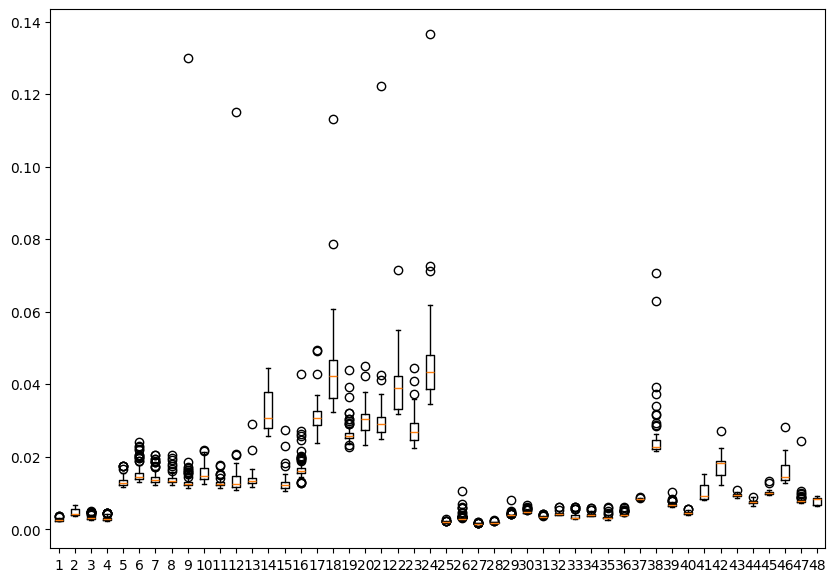

In [180]:
fig = plt.figure(figsize=(10, 7))
plt.boxplot(pd_runtimes["wall_time"])
plt.show()

In [181]:
for ckpt in pd_runtimes["checkpoint_path"].unique():
    print(ckpt)

checkpoints/glowing-snowball-134/step=7500--corr_dec=0.99.ckpt
checkpoints/northern-sky-137/step=5000--corr_dec=0.99.ckpt
checkpoints/gallant-deluge-140/step=7500--corr_dec=0.98.ckpt
checkpoints/devout-firebrand-144/step=7500--corr_dec=0.70.ckpt
checkpoints/dazzling-sound-135/step=6500--corr_dec=0.99.ckpt
checkpoints/rural-frog-149/step=4500--corr_dec=0.99.ckpt
checkpoints/dutiful-durian-141/step=6500--corr_dec=0.99.ckpt
checkpoints/sage-cosmos-146/step=14000--corr_dec=0.73.ckpt
checkpoints/snowy-haze-136/step=10000--corr_dec=1.00.ckpt
checkpoints/desert-tree-150/step=7500--corr_dec=1.00.ckpt
checkpoints/iconic-river-143/step=7500--corr_dec=0.99.ckpt
checkpoints/sweet-glade-147/step=11500--corr_dec=0.72.ckpt


In [182]:
ckpt_snowball = pd_runtimes[pd_runtimes["checkpoint_path"] == "checkpoints/glowing-snowball-134/step=7500--corr_dec=0.99.ckpt"]
sorted_ckpt_snowball = ckpt_snowball.sort_values(["run_on_cpu", "is_onnx"])
sorted_ckpt_snowball

,checkpoint_path,num_examples,is_onnx,run_on_cpu,wall_time,process_time,median_wall_time,median_process_time,loaded_model_hparams
0,checkpoints/glowing-snowball-134/step=7500--co...,100,False,False,"[0.0025900000000000003, 0.002431, 0.002519, 0....","[0.0025889999999999997, 0.002431, 0.00252, 0.0...",0.002542,0.002543,"{'architecture_config': {'arch': 'Unet', 'enco..."
24,checkpoints/glowing-snowball-134/step=7500--co...,100,True,False,"[0.0021319999999999998, 0.0023309999999999997,...","[0.0021939999999999998, 0.00239, 0.00221, 0.00...",0.001996,0.002027,"{'architecture_config': {'arch': 'Unet', 'enco..."
12,checkpoints/glowing-snowball-134/step=7500--co...,100,False,True,"[0.015965999999999998, 0.015905, 0.015954, 0.0...","[0.09596199999999999, 0.095873, 0.095889, 0.07...",0.013451,0.073939,"{'architecture_config': {'arch': 'Unet', 'enco..."
36,checkpoints/glowing-snowball-134/step=7500--co...,100,True,True,"[0.008466999999999999, 0.008320000000000001, 0...","[0.047390999999999996, 0.048368999999999995, 0...",0.008369,0.048363,"{'architecture_config': {'arch': 'Unet', 'enco..."


In [183]:
labels = []
for index, row in sorted_ckpt_snowball.iterrows():
    label = ""
    label += "onnx" if row["is_onnx"] else "torch"
    label += " "
    label += "cpu" if row["run_on_cpu"] else "gpu"
    labels.append(label)

labels

['torch gpu', 'onnx gpu', 'torch cpu', 'onnx cpu']

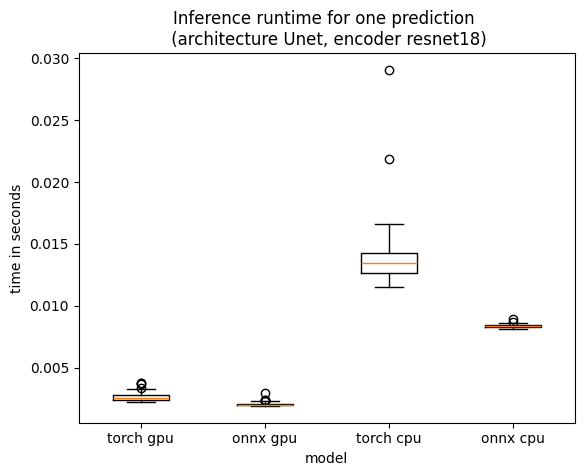

In [184]:
h_params = ckpt_snowball["loaded_model_hparams"][0]["architecture_config"]
fig = plt.figure()
plt.boxplot(sorted_ckpt_snowball["wall_time"], labels=labels)
plt.xlabel("model")
plt.ylabel("time in seconds")
plt.title(f"Inference runtime for one prediction \n (architecture {h_params['arch']}, encoder {h_params['encoder_name']})")
plt.show()

In [185]:
pd_runtimes["mean_wall_time"] = pd_runtimes["wall_time"].apply(np.mean)
pd_runtimes["mean_process_time"] = pd_runtimes["process_time"].apply(np.mean)

In [186]:
grouped = pd_runtimes.groupby(["run_on_cpu", "is_onnx"])
mean_runtimes = pd.DataFrame(grouped[["mean_wall_time", "mean_process_time"]].mean())
mean_runtimes = mean_runtimes.reset_index()
mean_runtimes

,run_on_cpu,is_onnx,mean_wall_time,mean_process_time
0,False,False,0.010564,0.010564
1,False,True,0.003370,0.003399
2,True,False,0.029017,0.172322
3,True,True,0.010859,0.064532


In [187]:
for col in ["mean_wall_time", "mean_process_time"]:
    print(col.upper())
    mean_torch_gpu = mean_runtimes[~mean_runtimes["run_on_cpu"] & ~mean_runtimes["is_onnx"]][col].item()
    mean_onnx_gpu = mean_runtimes[~mean_runtimes["run_on_cpu"] & mean_runtimes["is_onnx"]][col].item()
    print(f"{mean_torch_gpu=:.4}, {mean_onnx_gpu=:.4}")
    print(f"On average, onnx is {mean_torch_gpu/mean_onnx_gpu:.4} times faster on the gpu.")
    print()
    mean_torch_cpu = mean_runtimes[mean_runtimes["run_on_cpu"] & ~mean_runtimes["is_onnx"]][col].item()
    mean_onnx_cpu = mean_runtimes[mean_runtimes["run_on_cpu"] & mean_runtimes["is_onnx"]][col].item()
    print(f"{mean_torch_cpu=:.4}, {mean_onnx_cpu=:.4}")
    print(f"On average, onnx is {mean_torch_cpu/mean_onnx_cpu:.4} times faster on the cpu.")
    print("-" * 50)

MEAN_WALL_TIME
mean_torch_gpu=0.01056, mean_onnx_gpu=0.00337
On average, onnx is 3.134 times faster on the gpu.

mean_torch_cpu=0.02902, mean_onnx_cpu=0.01086
On average, onnx is 2.672 times faster on the cpu.
--------------------------------------------------
MEAN_PROCESS_TIME
mean_torch_gpu=0.01056, mean_onnx_gpu=0.003399
On average, onnx is 3.108 times faster on the gpu.

mean_torch_cpu=0.1723, mean_onnx_cpu=0.06453
On average, onnx is 2.67 times faster on the cpu.
--------------------------------------------------
